# Before you get started

## Data formatting

MINER is optimized for expression data of the form log2(TPM+1) or log2(FPKM+1). Expression data in counts format is not currently supported. 

If expression data is not Homo Sapiens, a reference database must be provided for mechanistic inference.

## Data location

This tutorial will import data stored in the "miner/data" folder. Before you start, move your data to the "miner/data" folder. 

## Special dependencies

These dependencies are not required for coexpression clustering or mechanistic inference, but are employed for optional functions in the miner library

Survival analysis:
    install lifelines

# Begin miner analysis

## Import standard dependencies

In [1]:
import numpy as np
import pandas as pd
from scipy import stats
from numpy import random as rd
import os
import json
from sklearn.decomposition import PCA
import multiprocessing, multiprocessing.pool
import matplotlib.pyplot as plt
import seaborn as sns
import time
from collections import Counter
from sklearn.manifold import TSNE
import pickle
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn import metrics
from sklearn import tree
import miner
%matplotlib inline
plt.style.use('ggplot')

In [2]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
from xgboost import XGBClassifier

## Create directory to save output files

In [3]:
# create name for results folder where output files will be saved
resultsFolder = "results_demo_2019.05.22"

# create results directory
resultsDirectory = os.path.join(os.path.split(os.getcwd())[0],resultsFolder)
if not os.path.isdir(resultsDirectory):
    os.mkdir(resultsDirectory)

# 0. Load and pre-process data; set parameters

In [27]:
# Load expression Data
expressionFile = os.path.join(os.path.split(os.getcwd())[0],"data","IA12Zscore.csv")
expressionData, conversionTable = miner.preprocess(expressionFile)
print(expressionData.shape)

completed identifier conversion.
16216 genes were converted.
(16216, 881)


Text(0.5,0,'Relative expression')

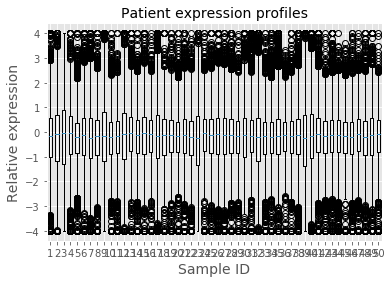

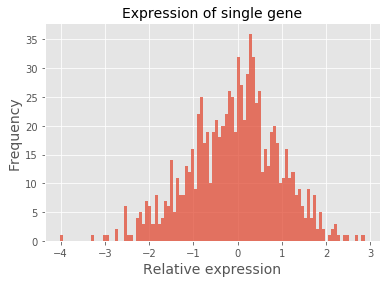

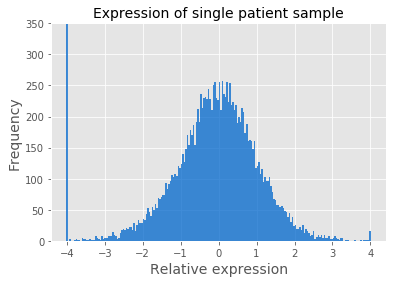

In [28]:
individual_expression_data = [expressionData.iloc[:,i] for i in range(50)]
_ = plt.boxplot(individual_expression_data)
plt.title("Patient expression profiles",FontSize=14)
plt.ylabel("Relative expression",FontSize=14)
plt.xlabel("Sample ID",FontSize=14)
plt.figure()
_ = plt.hist(expressionData.iloc[0,:],bins=100,alpha=0.75)
plt.title("Expression of single gene",FontSize=14)
plt.ylabel("Frequency",FontSize=14)
plt.xlabel("Relative expression",FontSize=14)
plt.figure()
_ = plt.hist(expressionData.iloc[:,0],bins=200,color=[0,0.4,0.8],alpha=0.75)
plt.ylim(0,350)
plt.title("Expression of single patient sample",FontSize=14)
plt.ylabel("Frequency",FontSize=14)
plt.xlabel("Relative expression",FontSize=14)

Text(0,0.5,'PC2')

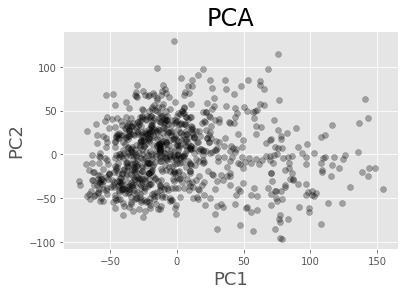

In [42]:
pca=PCA(n_components=2)
pca.fit(expressionData.T)
Y=pca.transform(expressionData.T)
plt.scatter(Y[:, 0],Y[:, 1],color='black',alpha=0.3)
plt.title('PCA',fontsize=24)
plt.xlabel('PC1',fontsize=18)
plt.ylabel('PC2',fontsize=18)

## Set parameters

In [6]:
# minimum number of genes that form an acceptable coexpression cluster:
minNumberGenes = 6 #bulk RNAseq default=6;single cell RNAseq default=6

# minimum correlation coefficient for an acceptable regulator-cluster association 
minCorrelation = 0.2 #bulk RNAseq default=0.2;single cell RNAseq default=0.05

# minimum number of genes that form an acceptable coexpression cluster and have share binding site for regulator:
minNumberRegulonGenes = 5 #bulk RNAseq default=5;single cell RNAseq default=4

# choose database: if supplying your own database, use mechanistic_database = reference_mechanistic_database
mechanistic_database = "tfbsdb_tf_to_genes.pkl" #default option
#mechanistic_database = reference_mechanistic_database #use if supplying your own database

# number of cores available for multiprocessing
numCores = 4

# 1. Co-expression clustering

0.00 percent complete


/Users/adriandelomana/anaconda3/envs/py2/lib/python2.7/site-packages/numpy/core/fromnumeric.py:56: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  return getattr(obj, method)(*args, **kwds)


20.00 percent complete
40.00 percent complete
60.00 percent complete
80.00 percent complete

coexpression clustering completed in 97.71 minutes
Number of genes clustered: 15196
Number of unique clusters: 1233
Completed clustering module in 101.96 minutes


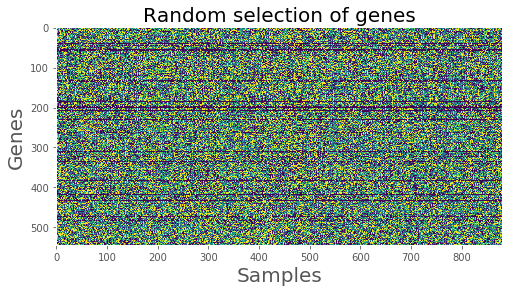

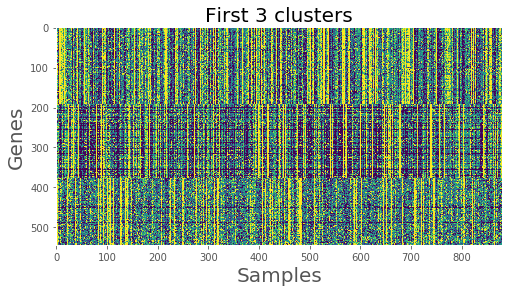

In [7]:
t1 = time.time()
# generate a list of coexpressed gene clusters, all of which have length >= minNumberGenes
initialClusters = miner.cluster(expressionData,minNumberGenes = minNumberGenes,minNumberOverExpSamples=4,maxSamplesExcluded=0.50,random_state=12,overExpressionThreshold=80) 
# revise initialClusters to combine highly correlated clusters and keep only those with significant coexpression
revisedClusters = miner.reviseInitialClusters(initialClusters,expressionData)
# write revisedClusters to .json file
miner.write_json(revisedClusters,os.path.join(resultsDirectory,"coexpressionDictionary.json"))
# ensure that keys have type str

# retrieve first three clusters for visual inspection
first_clusters = np.hstack([revisedClusters[i] for i in np.arange(3).astype(str)])

# visualize background expression
plt.figure(figsize=(8,4))
plt.imshow(expressionData.loc[np.random.choice(expressionData.index,len(first_clusters),replace=False),:],aspect="auto",cmap="viridis",vmin=-1,vmax=1)
plt.grid(False)
plt.ylabel("Genes",FontSize=20)
plt.xlabel("Samples",FontSize=20)
plt.title("Random selection of genes",FontSize=20)

# visualize first 10 clusters
plt.figure(figsize=(8,4))
plt.imshow(expressionData.loc[first_clusters,:],aspect="auto",cmap="viridis",vmin=-1,vmax=1)
plt.grid(False)
plt.ylabel("Genes",FontSize=20)
plt.xlabel("Samples",FontSize=20)
plt.title("First 3 clusters",FontSize=20)

# report coverage
print("Number of genes clustered: {:d}".format(len(set(np.hstack(initialClusters)))))
print("Number of unique clusters: {:d}".format(len(revisedClusters)))

t2 = time.time()
print("Completed clustering module in {:.2f} minutes".format((t2-t1)/60.))

# 2. Mechanistic inference

In [8]:
t1 = time.time()
# get first principal component axes of clusters
axes = miner.principalDf(revisedClusters,expressionData,subkey=None,minNumberGenes=1)
# analyze revised clusters for enrichment in relational database (default: transcription factor binding site database)
mechanisticOutput = miner.mechanisticInference(axes,revisedClusters,expressionData,correlationThreshold=minCorrelation,numCores=numCores,database=mechanistic_database)
# write mechanistic output to .json file
miner.write_json(mechanisticOutput,os.path.join(resultsDirectory,"mechanisticOutput.json"))
# order mechanisticOutput as {tf:{coexpressionModule:genes}} 
coregulationModules = miner.getCoregulationModules(mechanisticOutput)
# write coregulation modules to .json file
miner.write_json(coregulationModules,os.path.join(resultsDirectory,"coregulationModules.json"))
# get final regulons by keeping genes that requently appear coexpressed and associated to a common regulator
regulons = miner.getRegulons(coregulationModules,minNumberGenes=minNumberRegulonGenes,freqThreshold = 0.333)
# reformat regulon dictionary for consistency with revisedClusters and coexpressionModules
regulonModules, regulonDf = miner.regulonDictionary(regulons)
# write regulonDf to csv using preferred gene name identifiers
regulonDf.to_csv(os.path.join(resultsDirectory,"regulonDf.csv"))
# write regulons to json file
miner.write_json(regulonModules,os.path.join(resultsDirectory,"regulons.json"))
# define coexpression modules as composite of coexpressed regulons
coexpressionModules = miner.getCoexpressionModules(mechanisticOutput)
# write coexpression modules to .json file
miner.write_json(coexpressionModules,os.path.join(resultsDirectory,"coexpressionModules.json"))
#reconvert revised clusters to original gene annotations
annotatedRevisedClusters = miner.convertDictionary(revisedClusters,conversionTable)
# write annotated coexpression clusters to .json file
miner.write_json(revisedClusters,os.path.join(resultsDirectory,"coexpressionDictionary_annotated.json"))
#reconvert results into original annotations
regulonAnnotatedDf = miner.convertRegulons(regulonDf,conversionTable)
#write annotated regulon table to .csv
regulonAnnotatedDf.to_csv(os.path.join(resultsDirectory,"regulons_annotated.csv"))
#reconvert regulons
annotatedRegulons = miner.convertDictionary(regulonModules,conversionTable)
# write annotated regulons to .json file
miner.write_json(annotatedRegulons,os.path.join(resultsDirectory,"regulons_annotated.json"))
#reconvert coexpression modules
annotatedCoexpressionModules = miner.convertDictionary(coexpressionModules,conversionTable)
# write annotated coexpression modules to .json file
miner.write_json(annotatedCoexpressionModules,os.path.join(resultsDirectory,"coexpressionModules_annotated.json"))
t2 = time.time()
print("Completed mechanistic inference in {:.2f} minutes".format((t2-t1)/60.))
print("Inferred network with {:d} regulons, {:d} regulators, and {:d} co-regulated genes".format(len(regulonDf.Regulon_ID.unique()),len(regulonDf.Regulator.unique()),len(regulonDf.Gene.unique())))

Running mechanistic inference


/Users/adriandelomana/anaconda3/envs/py2/lib/python2.7/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)
miner.py:975: RuntimeWarning: invalid value encountered in greater_equal
  tfDict[axes[axis]] = tfs[np.where(np.abs(tfCorrelation)>=correlationThreshold)[0]]


Completed mechanistic inference in 13.80 minutes
Inferred network with 3203 regulons, 392 regulators, and 8549 co-regulated genes


In [9]:
regulon_id = 10
regulonDf[regulonDf.Regulon_ID==str(regulon_id)]

,Regulon_ID,Regulator,Gene
125,10,ENSG00000134954,ENSG00000160318
126,10,ENSG00000134954,ENSG00000158373
127,10,ENSG00000134954,ENSG00000124067
128,10,ENSG00000134954,ENSG00000174177
129,10,ENSG00000134954,ENSG00000197061
130,10,ENSG00000134954,ENSG00000167523


# 3. Network mapping

In [10]:
t1 = time.time()
# select reference dictionary for downstream analysis (revisedClusters, coexpressionModules, or regulonModules)
referenceDictionary = regulonModules
# create a background matrix used for statistical hypothesis testing
bkgd = miner.backgroundDf(expressionData)
# for each cluster, give samples that show high coherent cluster activity
overExpressedMembers = miner.biclusterMembershipDictionary(referenceDictionary,bkgd,label=2,p=0.05)
# for each cluster, give samples that show low coherent cluster activity
underExpressedMembers = miner.biclusterMembershipDictionary(referenceDictionary,bkgd,label=0,p=0.05)
# for each cluster, give samples that do not show coherent cluster activity
dysregulatedMembers = miner.biclusterMembershipDictionary(referenceDictionary,bkgd,label="excluded")
# for each cluster, give samples that show coherent cluster activity, despite magnitude of expression
coherentMembers = miner.biclusterMembershipDictionary(referenceDictionary,bkgd,label="included")

# write membership matrices to .csv file
overExpressedMembersMatrix = miner.membershipToIncidence(overExpressedMembers,expressionData)
overExpressedMembersMatrix.to_csv(os.path.join(resultsDirectory,"overExpressedMembers.csv"))
underExpressedMembersMatrix = miner.membershipToIncidence(underExpressedMembers,expressionData)
underExpressedMembersMatrix.to_csv(os.path.join(resultsDirectory,"underExpressedMembers.csv"))
dysregulatedMembersMatrix = miner.membershipToIncidence(dysregulatedMembers,expressionData)
dysregulatedMembersMatrix.to_csv(os.path.join(resultsDirectory,"dysregulatedMembers.csv"))
coherentMembersMatrix = miner.membershipToIncidence(coherentMembers,expressionData)
coherentMembersMatrix.to_csv(os.path.join(resultsDirectory,"coherentMembers.csv"))

t2 = time.time()
print("Completed patient mapping in {:.2f} minutes".format((t2-t1)/60.))

done!
done!
done!
done!
Completed patient mapping in 256.09 minutes


Text(0.5,0,'Samples')

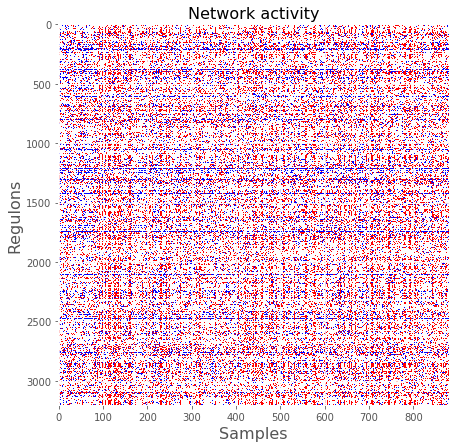

In [30]:
#visualize network activity across individual samples
plt.figure(figsize=(7,7))
network_activity_heatmap = overExpressedMembersMatrix-underExpressedMembersMatrix
plt.imshow(network_activity_heatmap,cmap="bwr",vmin=-1,vmax=1,aspect="auto")
plt.title("Network activity",FontSize=16)
plt.ylabel("Regulons",FontSize=16)
plt.xlabel("Samples",FontSize=16)

# 4. Subtype discovery

done!
completed in 13.06 minutes


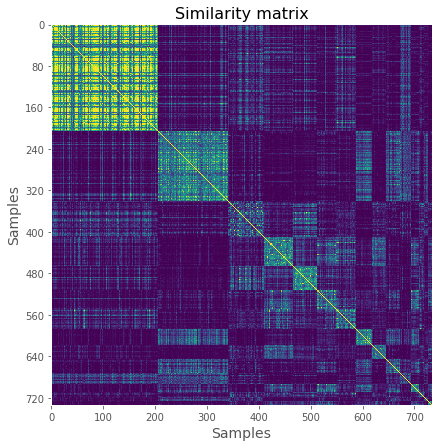

In [12]:
t1 = time.time()
# choose membership type for sample class prediction
sampleDictionary = overExpressedMembers
sampleMatrix = overExpressedMembersMatrix
sampleUnderMatrix = underExpressedMembersMatrix

# perform initial subtype clustering
similarityClusters = miner.f1Decomposition(sampleDictionary,thresholdSFM=0.1)
initialClasses = [i for i in similarityClusters if len(i)>4]

# visualize initial results
sampleFrequencyMatrix = miner.sampleCoincidenceMatrix(sampleDictionary,freqThreshold = 0.333,frequencies=True) #0.333
similarityMatrix = sampleFrequencyMatrix*sampleFrequencyMatrix.T
miner.plotSimilarity(similarityMatrix,np.hstack(initialClasses),vmin=0,vmax=0.5,title="Similarity matrix",xlabel="Samples",ylabel="Samples",fontsize=14,figsize=(7,7),savefig=os.path.join(resultsDirectory,"similarityMatrix_regulons.pdf"))
t2 = time.time()
print("completed in {:.2f} minutes".format((t2-t1)/60.))

completed in 1.79 minutes


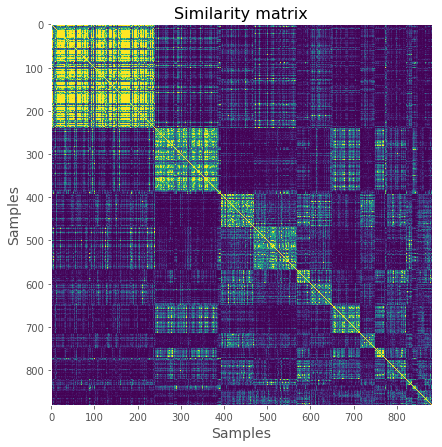

In [13]:
t1 = time.time()
# expand initial subtype clusters
centroidClusters, centroidMatrix = miner.centroidExpansion(initialClasses,sampleMatrix,f1Threshold = 0.1,returnCentroids=True) #0.3
centroidMatrix.to_csv(os.path.join(resultsDirectory,"centroids.csv"))
unmapped = list(sampleMatrix.columns[np.where(sampleMatrix.sum(axis=0)==0)[0]])
mappedSamples = [i for i in np.hstack(centroidClusters) if i not in unmapped]
mappedClusters = miner.mapExpressionToNetwork(centroidMatrix,sampleMatrix,threshold = 0.05)

# visualize expanded subtype clusters
miner.plotSimilarity(similarityMatrix,mappedSamples,vmin=0,vmax=0.333,title="Similarity matrix",xlabel="Samples",ylabel="Samples",fontsize=14,figsize=(7,7),savefig=os.path.join(resultsDirectory,"centroidClusters_regulons.pdf"))
t2 = time.time()
print("completed in {:.2f} minutes".format((t2-t1)/60.))

completed in 0.86 minutes


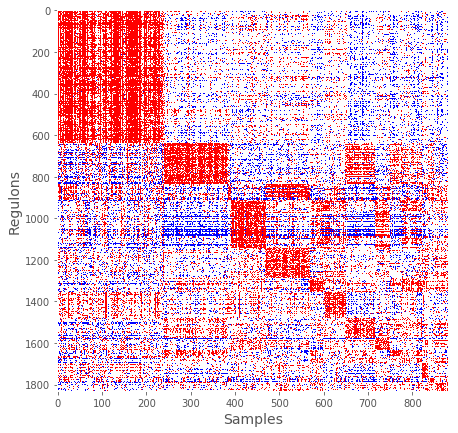

In [34]:
t1 = time.time()
# Get eigengenes for all modules
eigengenes = miner.getEigengenes(referenceDictionary,expressionData,regulon_dict=None,saveFolder=None)
eigenScale = np.percentile(expressionData,95)/np.percentile(eigengenes,95)
eigengenes = eigenScale*eigengenes
eigengenes.index = np.array(eigengenes.index).astype(str)

# Generate heatmaps of module activity 
orderedDM = miner.plotDifferentialMatrix(sampleMatrix,sampleUnderMatrix,orderedOverExpressedMembers,cmap="bwr",aspect="auto",saveFile=os.path.join(resultsDirectory,"centroid_clusters_heatmap.pdf"),showplot=True)
orderedOverExpressedMembers = miner.orderMembership(centroidMatrix,sampleMatrix,mappedClusters,ylabel="Regulons",resultsDirectory=None,showplot=False)
t2 = time.time()
print("completed in {:.2f} minutes".format((t2-t1)/60.))

Discovered 29 transcriptional states and 80 transcriptional programs
sample coverage within sufficiently large states: 97.4%
completed subtype inference in 3.92 minutes


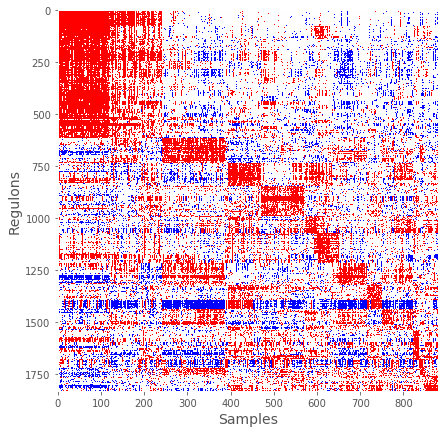

In [19]:
t1 = time.time()
# Infer transcriptional programs and states
programs, states = miner.mosaic(dfr=orderedDM,clusterList=centroidClusters,minClusterSize_x=int(np.ceil(0.01*expressionData.shape[1])),minClusterSize_y=5,allow_singletons=False,max_groups=50,saveFile=os.path.join(resultsDirectory,"regulon_activity_heatmap.pdf"),random_state=12)   
transcriptional_programs, program_regulons = miner.transcriptionalPrograms(programs,referenceDictionary)
program_list = [program_regulons[("").join(["TP",str(i)])] for i in range(len(program_regulons))]
mosaicDf = orderedDM.loc[np.hstack(program_list),np.hstack(states)]
mosaicDf.to_csv(os.path.join(resultsDirectory,"regulons_activity_heatmap.csv"))
# calculate percent of samples that fall into a state with >= minimum acceptable number of samples
groups = [states[i] for i in range(len(states)) if len(states[i])>=int(np.ceil(0.01*expressionData.shape[1]))]
print('Discovered {:d} transcriptional states and {:d} transcriptional programs'.format((len(states)),len(transcriptional_programs)))
print('sample coverage within sufficiently large states: {:.1f}%'.format(100*float(len(np.hstack(groups)))/expressionData.shape[1]))

#write all transcriptional program genesets to text files for external analysis
if not os.path.isdir(os.path.join(resultsDirectory,"transcriptional_programs_coexpressionModules")):
    os.mkdir(os.path.join(resultsDirectory,"transcriptional_programs_coexpressionModules"))
    
for tp in transcriptional_programs.keys():
    np.savetxt(os.path.join(resultsDirectory,"transcriptional_programs_coexpressionModules",(".").join([tp,"txt"])),transcriptional_programs[tp],fmt="%1.50s")
    
# Determine activity of transcriptional programs in each sample
statesDf = miner.reduceModules(df=orderedDM,programs=program_list,states=states,stateThreshold=0.65,saveFile=None)

# Cluster patients into subtypes and give the activity of each program in each subtype
programsVsStates = miner.programsVsStates(statesDf,states,filename=None)

t2 = time.time()
print("completed subtype inference in {:.2f} minutes".format((t2-t1)/60.))

# 5. Causal inference

In [21]:
# Load mutation matrices
common_mutations_file = os.path.join(os.path.split(os.getcwd())[0],"data","mutations.csv")
common_mutations = pd.read_csv(common_mutations_file,index_col=0,header=0)

translocations_file = os.path.join(os.path.split(os.getcwd())[0],"data","translocationsIA12.csv")
translocations = pd.read_csv(translocations_file,index_col=0,header=0)

cytogenetics_file = os.path.join(os.path.split(os.getcwd())[0],"data","cytogenetics.csv")
cytogenetics = pd.read_csv(cytogenetics_file,index_col=0,header=0)

In [22]:
reload(miner)
# Perform causal analysis for each mutation matrix
mut_matrix = common_mutations.copy()
miner.causalNetworkAnalysis(regulon_matrix=regulonDf.copy(),expression_matrix=expressionData.copy(),reference_matrix=eigengenes.copy(),mutation_matrix=mut_matrix,resultsDirectory=os.path.join(resultsDirectory,"causal_analysis"),minRegulons=1,significance_threshold=0.05,causalFolder="causal_results_common_mutations")

mut_matrix = translocations.copy()
miner.causalNetworkAnalysis(regulon_matrix=regulonDf.copy(),expression_matrix=expressionData.copy(),reference_matrix=eigengenes.copy(),mutation_matrix=mut_matrix,resultsDirectory=os.path.join(resultsDirectory,"causal_analysis"),minRegulons=1,significance_threshold=0.05,causalFolder="causal_results_translocations")

mut_matrix = cytogenetics.copy()
miner.causalNetworkAnalysis(regulon_matrix=regulonDf.copy(),expression_matrix=expressionData.copy(),reference_matrix=eigengenes.copy(),mutation_matrix=mut_matrix,resultsDirectory=os.path.join(resultsDirectory,"causal_analysis"),minRegulons=1,significance_threshold=0.05,causalFolder="causal_results_cytogenetics")

# compile all causal results
causal_directory = os.path.join(resultsDirectory,"causal_analysis")
causal_results = miner.readCausalFiles(causal_directory)
causal_results.to_csv(os.path.join(resultsDirectory,"completeCausalResults.csv"))
causal_results.loc[causal_results['Mutation'] == 'CCND1'].head(20)

/Users/adriandelomana/anaconda3/envs/py2/lib/python2.7/site-packages/numpy/core/fromnumeric.py:3367: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/Users/adriandelomana/anaconda3/envs/py2/lib/python2.7/site-packages/numpy/core/_methods.py:130: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/Users/adriandelomana/anaconda3/envs/py2/lib/python2.7/site-packages/scipy/stats/_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/adriandelomana/anaconda3/envs/py2/lib/python2.7/site-packages/scipy/stats/_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/adriandelomana/anaconda3/envs/py2/lib/python2.7/site-packages/scipy/stats/_distn_infrastructure.py:1831: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


completed causal analysis in 41.17 minutes
completed causal analysis in 0.82 minutes
completed causal analysis in 0.73 minutes


,Mutation,Regulator,Regulon,MutationRegulatorEdge,-log10(p)_MutationRegulatorEdge,RegulatorRegulon_Spearman_R,RegulatorRegulon_Spearman_p-value,Regulon_stratification_t-statistic,-log10(p)_Regulon_stratification,Fraction_of_edges_correctly_aligned
1490,CCND1,ENSG00000197063,R-1490,1.0,4.169359,0.329607,9.037739e-24,9.943572,1.753590,1.0
1492,CCND1,ENSG00000197063,R-1492,1.0,4.169359,0.179918,7.590136e-08,13.843372,1.651022,1.0
1495,CCND1,ENSG00000197063,R-1495,1.0,4.169359,-0.248125,7.932746e-14,-26.255247,3.515866,1.0
1485,CCND1,ENSG00000197063,R-1485,1.0,4.169359,-0.359164,3.232710e-28,-14.047707,2.120916,1.0
1489,CCND1,ENSG00000197063,R-1489,1.0,4.169359,-0.325313,3.654979e-23,-9.367345,1.979225,1.0
1497,CCND1,ENSG00000197063,R-1497,1.0,4.169359,0.090822,6.986041e-03,30.047940,47.901484,1.0
2371,CCND1,ENSG00000169635,R-2371,1.0,11.428439,-0.078403,1.994360e-02,-22.553972,5.647388,1.0
2638,CCND1,ENSG00000143799,R-2638,-1.0,3.689126,-0.178340,9.893034e-08,9.524707,1.464380,1.0
2635,CCND1,ENSG00000143799,R-2635,-1.0,3.689126,-0.278270,3.944593e-17,20.950814,2.121620,1.0
2637,CCND1,ENSG00000143799,R-2637,-1.0,3.689126,-0.278946,3.288451e-17,10.468012,1.443063,1.0


# 6. Risk prediction

## 6.1. Risk by subtype

24
10
                               HR       p-value
10&20&19&5&18&21         8.222212  1.997832e-16
10&20&19&5               8.144445  3.810259e-16
10&20&19&5&18            8.080770  6.435921e-16
10&20&19&5&18&21&7       7.833175  4.757019e-15
10&20&19&5&18&21&7&0     6.640770  3.120478e-11
10&20&19                 6.630914  3.336138e-11
10&20&19&5&18&21&7&0&9   6.405954  1.494317e-10
10&20                    5.975608  2.292341e-09
10                       4.394349  1.111053e-05
14                      -2.502436  1.233419e-02
14&11                   -2.604498  9.200904e-03
14&11&8                 -2.686576  7.218850e-03
14&11&8&4               -3.489739  4.834926e-04
14&11&8&4&23            -3.785021  1.536955e-04
14&11&8&4&23&3          -4.334561  1.460516e-05
14&11&8&4&23&3&12       -4.653919  3.256841e-06
14&11&8&4&23&3&12&17    -4.741333  2.123164e-06
14&11&8&4&23&3&12&17&16 -4.858626  1.182030e-06
completed combinatorial transcriptional state survival analysis in 1.04 minutes


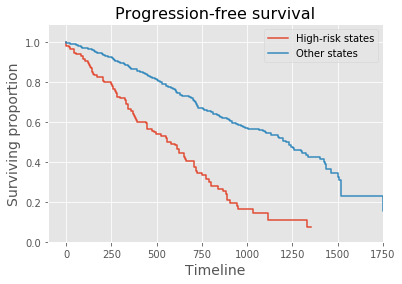

In [23]:
t1 = time.time()

# load survival data
survivalMMRF = pd.read_csv(os.path.join("..","data","survival.csv"),index_col=0,header=0)
survivalDfMMRF = survivalMMRF.iloc[:,0:2]
survivalDfMMRF.columns = ["duration","observed"]
overExpressedMembersMatrixMMRF = overExpressedMembersMatrix
overExpressedMembersMatrixMMRF = overExpressedMembersMatrixMMRF.loc[orderedOverExpressedMembers.index,:]

#generate Kaplan-Meier estimates
kmDf = miner.kmAnalysis(survivalDf=survivalDfMMRF,durationCol="duration",statusCol="observed")
#generate GuanRank scores
guanSurvivalDfMMRF = miner.guanRank(kmSurvival=kmDf)

# Visualize risk associated with each transcriptional state

srv = guanSurvivalDfMMRF.copy()
guan_srv = pd.DataFrame(srv.loc[:,"GuanScore"])
guan_srv.columns = ["value"]
guan_srv_group = pd.DataFrame(-np.ones(guan_srv.shape[0]))
guan_srv_group.index = guan_srv.index
guan_srv_group.columns = ["group"]
guan_srv_df = pd.concat([guan_srv,guan_srv_group],axis=1)

mmrf_groups = [i for i in states if len(set(srv.index)&set(i)) >= 5]
labels = range(len(mmrf_groups))

xmedians = []
for i in range(len(mmrf_groups)):
    group = list(set(srv.index)&set(mmrf_groups[i]))
    if len(group)>=1:
        xmedians.append(np.median(guan_srv_df.loc[group,"value"]))
    elif len(group)<1:
        xmedians.append(0)
    label = labels[i]
    guan_srv_df.loc[group,"group"] = label
print(len(xmedians))

ranked_states = np.argsort(xmedians)

survival_tag = "Risk_groups"

# Combinatorial survival analysis
combined_states, combined_indices = miner.combinedStates(mmrf_groups,ranked_states,srv,minSamples=4,maxStates=10)

state_members = combined_states
sufficient_states = range(len(combined_states))
state_survival = pd.DataFrame(np.zeros((len(state_members),srv.shape[0])))
state_survival.index = sufficient_states
state_survival.columns = srv.index
for ix in range(len(sufficient_states)):
    sm = list(set(state_members[ix])&set(srv.index))
    state_survival.loc[sufficient_states[ix],sm] = 1
    
cox_combined_states = miner.parallelMemberSurvivalAnalysis(membershipDf = state_survival,numCores=1,survivalPath="",survivalData=srv)

cox_hr = [cox_combined_states[i][0] for i in cox_combined_states.keys()]
cox_p = [cox_combined_states[i][1] for i in cox_combined_states.keys()]
cox_combined_states_df = pd.DataFrame(np.vstack([cox_hr,cox_p]).T)
cox_combined_states_df.index = combined_indices
cox_combined_states_df.columns = ["HR","p-value"]
cox_combined_states_df.sort_values(by="HR",ascending=False,inplace=True)
cox_combined_states_df.to_csv(os.path.join(resultsDirectory,"Hazards_regression_of_combined_transcriptional_states.csv"))
print(cox_combined_states_df)

highest_risk_combination = np.array(cox_combined_states_df.index[0].split("&")).astype(int)
lowest_risk_combination = np.array(cox_combined_states_df.index[-1].split("&")).astype(int)

kmTag = "states"
kmFilename = ("_").join([survival_tag,kmTag,".pdf"])
groups = [np.hstack([mmrf_groups[i] for i in highest_risk_combination]),np.hstack([mmrf_groups[i] for i in range(len(mmrf_groups)) if i not in highest_risk_combination])]
labels = np.arange(len(groups)).astype(str)
labels = ["High-risk states","Other states"]
plotName = os.path.join(resultsDirectory,kmFilename)
miner.kmplot(srv=srv,groups=groups,labels=labels,xlim_=(-100,1750),filename=plotName)  

t2 = time.time()
print("completed combinatorial transcriptional state survival analysis in {:.2f} minutes".format((t2-t1)/60.))

## 6.2. Risk by decision-tree of network features

In [ ]:
# GSE24080UAMS
expressionDataGSE24080UAMS = pd.read_csv(os.path.join("..","dream","GSE24080UAMSentrezIDlevel.csv"),index_col=0,header=0)
expressionDataGSE24080UAMS, _ = miner.identifierConversion(expressionData=expressionDataGSE24080UAMS)
expressionDataGSE24080UAMS = miner.zscore(expressionDataGSE24080UAMS)
bkgdGSE24080UAMS = miner.backgroundDf(expressionDataGSE24080UAMS)
overExpressedMembersGSE24080UAMS = miner.biclusterMembershipDictionary(regulonModules,bkgdGSE24080UAMS,label=2,p=0.1)
overExpressedMembersMatrixGSE24080UAMS = miner.membershipToIncidence(overExpressedMembersGSE24080UAMS,expressionDataGSE24080UAMS)

# GSE19784HOVON65 
expressionDataGSE19784HOVON65 = pd.read_csv(os.path.join("..","dream","GSE19784HOVON65entrezIDlevel.csv"),index_col=0,header=0)
expressionDataGSE19784HOVON65, _ = miner.identifierConversion(expressionData=expressionDataGSE19784HOVON65)
expressionDataGSE19784HOVON65 = miner.zscore(expressionDataGSE19784HOVON65)
bkgdGSE19784HOVON65 = miner.backgroundDf(expressionDataGSE19784HOVON65)
overExpressedMembersGSE19784HOVON65 = miner.biclusterMembershipDictionary(regulonModules,bkgdGSE19784HOVON65,label=2,p=0.1)
overExpressedMembersMatrixGSE19784HOVON65 = miner.membershipToIncidence(overExpressedMembersGSE19784HOVON65,expressionDataGSE19784HOVON65)

# EMTAB4032
expressionDataEMTAB4032 = pd.read_csv(os.path.join("..","dream","EMTAB4032entrezIDlevel.csv"),index_col=0,header=0)
expressionDataEMTAB4032, _ = miner.identifierConversion(expressionData=expressionDataEMTAB4032)
expressionDataEMTAB4032 = miner.zscore(expressionDataEMTAB4032)
bkgdEMTAB4032 = miner.backgroundDf(expressionDataEMTAB4032)
overExpressedMembersEMTAB4032 = miner.biclusterMembershipDictionary(regulonModules,bkgdEMTAB4032,label=2,p=0.1)
overExpressedMembersMatrixEMTAB4032 = miner.membershipToIncidence(overExpressedMembersEMTAB4032,expressionDataEMTAB4032)